<div style = "text-align:center; font-size: 28px; font-weight: bold;"> Predictive Service Delay Management for CTA Trains</div>
<br>


This notebook reflects the necessary steps taken to arrive at a functioning predictive model for the Chicago Transit Authority (CTA).

### Import Necessary Libraries

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Import the Dataset

The dataset is based on real-time data, and is sourced from two separate APIs, the CTA Train Tracker API, and TomTom's Traffic Flow RESTful API.

In [18]:
# The dataset has no column headers, so we are applying column labels based on the API script used to scrape the data
column_labels = [
    "station_id", "line", "predicted_time", "arrival_time", 
    "isSch", "isFlt", "isDly", 
    "station_name", "destination_name", "lat", "long", 
    "free_flow_speed", "current_speed"
]

df = pd.read_csv("combined_data.csv", header = None, names = column_labels)

In [19]:
df.sample(n = 5)

,station_id,line,predicted_time,arrival_time,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed
3602,40880,Red,20230810 12:45:35,20230810 13:19:35,0,0,0,Thorndale,Howard,41.86740,-87.62740,24,24
85221,40610,G,20230815 21:15:45,20230815 21:58:45,0,0,0,Ridgeland,Harlem/Lake,41.81646,-87.61904,19,19
93135,41170,Red,20230818 01:03:41,20230818 01:12:41,0,0,0,Garfield,Howard,41.75042,-87.62518,67,67
84985,40890,Blue,20230815 19:22:31,20230815 19:33:31,0,0,0,O'Hare,O'Hare,41.98250,-87.81446,65,65
36111,40890,Blue,20230810 20:52:20,20230810 21:23:20,0,0,0,O'Hare,O'Hare,41.92460,-87.70125,16,12


Some of these column headers may be hard to decipher. Let's clarify what they mean.

Per the CTA Train Tracker API:

**predicted_time** = "Date-time format stamp for when the prediction was generated:
yyyyMMdd HH:mm:ss (24-hour format, time local to Chicago)"

**arrival_time** = "Date-time format stamp for when a train is expected to arrive/depart:
yyyyMMdd HH:mm:ss (24-hour format, time local to Chicago)"

**isSch** = "Boolean flag to indicate whether this is a live prediction or based on
schedule in lieu of live data"

**isFlt** = "Boolean flag to indicate whether a potential fault has been detected"

>"The **isFlt** element in the results indicates what we call a “schedule fault” in the context of Train Tracker.
A fault on an ETA that is schedule-based (isSch=1) indicates that the scheduled arrival time given
might not be feasible to serve due to the lack of a scheduled departure having occurred."

**isDly** = "Boolean flag to indicate whether a train is considered “delayed” in Train
Tracker"

**lat** = "Latitude position of the train in decimal degrees"

**long** = "Longitude position of the train in decimal degrees"

Per TomTom's Traffic Flow RESTful API:

**free_flow_speed** = "The free flow speed expected under ideal conditions, expressed in [MPH]

**current_speed** = "The current average speed at the selected [latitude and longitude], in [MPH]."

>Note that these speeds fetched from the TomTom API *do not* directly refer to the train itself; they are not train speeds. Rather, they are referring to the *traffic speeds* of the roads closest to the geographical coordinates of the specifc train.

<div style = "text-align:center; font-size: 24px; font-weight: bold;"> Exploratory Data Analysis (EDA)</div>


Now, from these points of clarity, we can make several observations.
First, let's see how many already-classified delays there are in this dataset.

In [20]:
df['isDly'].value_counts()

0    106014
1       504
Name: isDly, dtype: int64

Out of more than **100,000** total train-tracking instances in this dataset, only around **500** of them are **delay-positive**. 

Per the CTA Train Tracker API documentation:

>"The CTA Train Tracker service looks at how long it’s been since a train has moved from one track
circuit to the next and identifies delays if a train appears to not be moving."

Next, let's see how many instances are based on schedule or have a potential fault. 

In [21]:
df['isSch'].value_counts()

0    106518
Name: isSch, dtype: int64

In [22]:
df['isFlt'].value_counts()

0    106518
Name: isFlt, dtype: int64

Out of the entire dataset, every train so far is based on live predictions and has not had a fault.

<div style = "text-align:left; font-size: 18px; font-weight: normal;"> Now, let's return to delays, and analyze them further. Let's see how many recorded delays there are for every specific line.  </div>

>For those who are not native to Chicago, the city's train system consists of multiple colored lines, each of which is associated with a color name.

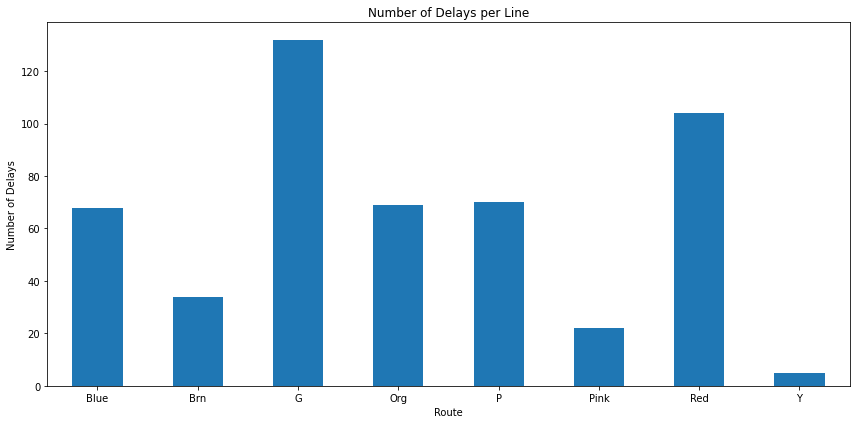

In [25]:
route_delay_counts = df.groupby('line')['isDly'].sum()

plt.figure(figsize = (12,6))
route_delay_counts.plot(kind = 'bar')
plt.xlabel('Route')
plt.ylabel('Number of Delays')
plt.title('Number of Delays per Line')
plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()


<div style = "text-align:left; font-size: 18px; font-weight: normal;"> Now let's analyze delays per station. </div>

Station ID with the most delays: 40100
Delay count: 13


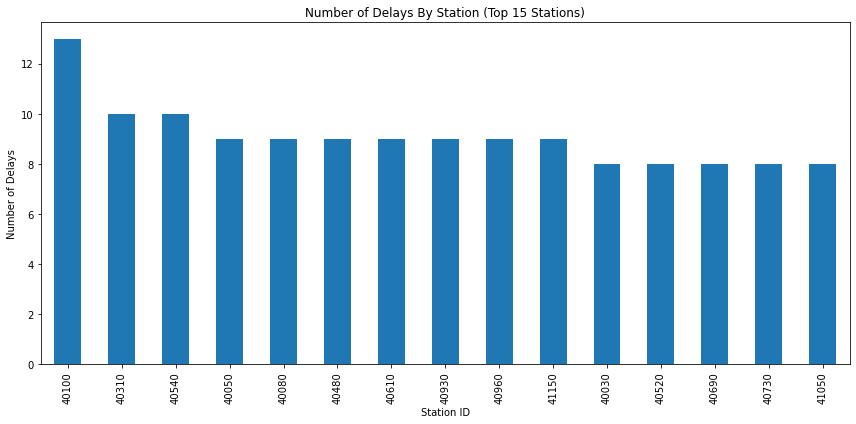

In [27]:
station_delay_counts = df.groupby('station_id')['isDly'].sum()

most_delay_station = station_delay_counts.idxmax()

most_delay_station

most_delay_count = station_delay_counts.loc[most_delay_station]

print("Station ID with the most delays:", most_delay_station)
print("Delay count:", most_delay_count)

#------------------------------------------------------------------

top_n = 15
top_delay_stations = station_delay_counts.nlargest(top_n).index

plt.figure(figsize = (12,6))
station_delay_counts.loc[top_delay_stations].plot(kind = 'bar', stacked = True)
plt.xlabel('Station ID')
plt.ylabel('Number of Delays')
plt.title(f"Number of Delays By Station (Top {top_n} Stations)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

<div style = "text-align:left; font-size: 18px; font-weight: normal;"> Now let's look at delays per hour. </div>

In [32]:
# Convert 'predicted_time' to datetime
df['predicted_time'] = pd.to_datetime(df['predicted_time'])

# Create a list of all hours (0 to 23)
all_hours = list(range(24))

# Create a DataFrame with all hours
hourly_delays = pd.DataFrame({'hour_of_day': all_hours})

# Merge the original data with the all hours DataFrame to count delays for each hour
hourly_delays = hourly_delays.merge(df.groupby(df['predicted_time'].dt.hour)['isDly'].sum().reset_index(), 
                                    how = 'left', left_on = 'hour_of_day', right_on = 'predicted_time')

# Fill NaN values with 0 (no delays)
hourly_delays['isDly'] = hourly_delays['isDly'].fillna(0).astype(int)

# Drop the redundant 'predicted_time' column
hourly_delays.drop(columns=['predicted_time'], inplace = True)

# Rename columns
hourly_delays.columns = ['hour_of_day', 'number_of_delays']

# Print the new DataFrame
hourly_delays

,hour_of_day,number_of_delays
0,0,19
1,1,19
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


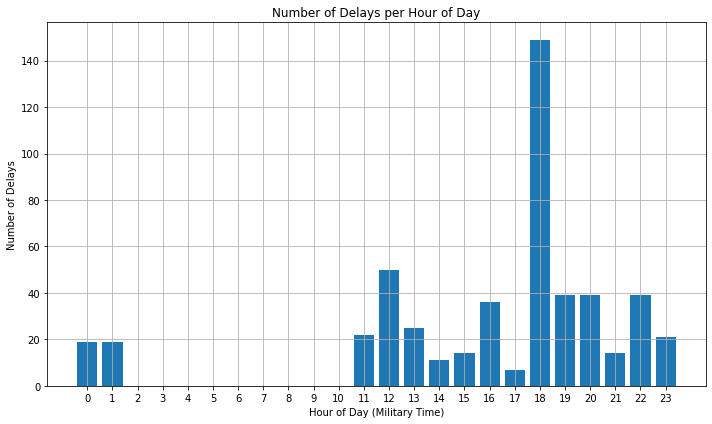

In [30]:
plt.figure(figsize=(10, 6))
plt.bar(hourly_delays['hour_of_day'], hourly_delays['number_of_delays'])
plt.xlabel('Hour of Day (Military Time)')
plt.ylabel('Number of Delays')
plt.title('Number of Delays per Hour of Day')
plt.xticks(all_hours)
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="text-align:center; font-size: 24px; font-weight: bold;"> Data Preprocessing </div>
<br style="line-height: 3px;">
<div style="text-align:center; font-size: 18px; font-weight: normal;"> Feature Engineering </div>